# Cox-PH and DeepSurv

In this notebook we will train the [Cox-PH method](http://jmlr.org/papers/volume20/18-424/18-424.pdf), also known as [DeepSurv](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1).
We will use the METABRIC data sets as an example

A more detailed introduction to the `pycox` package can be found in [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb) about the `LogisticHazard` method.

The main benefit Cox-CC (and the other Cox methods) has over Logistic-Hazard is that it is a continuous-time method, meaning we do not need to discretize the time scale.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [3]:
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas

In [4]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set and split in train, test and validation.

In [5]:
import pandas as pd

df_train = pd.read_csv('data/Recurrence free survival in breast cancer patients.csv')
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [6]:
df_train.head()

,id,treat,age,men,size,grade,nodes,prog,oest,time,status
0,1,0,70,2,21,2,3,48,66,1814,1
1,2,1,56,2,12,2,7,61,77,2018,1
2,3,1,58,2,35,2,9,52,271,712,1
3,4,1,59,2,17,2,4,60,29,1807,1
4,5,0,73,2,35,2,1,26,65,772,1


## Feature transforms
We have 9 covariates, in addition to the durations and event indicators.

We will standardize the 5 numerical covariates, and leave the binary variables as is. As variables needs to be of type `'float32'`, as this is required by pytorch.

In [7]:
cols_standardize = ['treat', 'age', 'men', 'size', 'grade', 'nodes', 'prog', 'oest']
cols_leave = []

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [8]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

We need no label transforms

In [10]:
get_target = lambda df: (df['time'].values, df['status'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

## Neural net

We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. 
Here, we just use the `torchtuples.practical.MLPVanilla` net to do this.

Note that we set `out_features` to 1, and that we have not `output_bias`.

In [11]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, but here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`. See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

In [12]:
model = CoxPH(net, tt.optim.Adam)

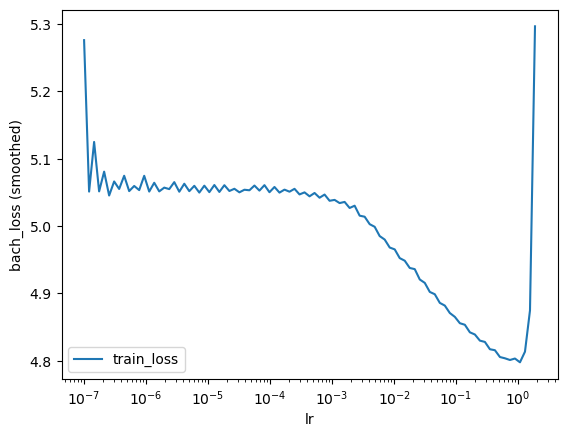

In [13]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [14]:
lrfinder.get_best_lr()

0.10722672220103299

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [15]:
model.optimizer.set_lr(0.01)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [16]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [17]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.9884,	val_loss: 4.0788
1:	[0s / 0s],		train_loss: 4.7227,	val_loss: 4.1844
2:	[0s / 0s],		train_loss: 4.6817,	val_loss: 4.3694
3:	[0s / 0s],		train_loss: 4.6227,	val_loss: 4.3148
4:	[0s / 0s],		train_loss: 4.6195,	val_loss: 4.1700
5:	[0s / 0s],		train_loss: 4.5891,	val_loss: 4.1102
6:	[0s / 0s],		train_loss: 4.5458,	val_loss: 4.0793
7:	[0s / 0s],		train_loss: 4.5441,	val_loss: 4.0651
8:	[0s / 0s],		train_loss: 4.5143,	val_loss: 4.0734
9:	[0s / 0s],		train_loss: 4.5345,	val_loss: 4.0936
10:	[0s / 0s],		train_loss: 4.5036,	val_loss: 4.1134
11:	[0s / 0s],		train_loss: 4.5120,	val_loss: 4.1411
12:	[0s / 0s],		train_loss: 4.4866,	val_loss: 4.1619
13:	[0s / 0s],		train_loss: 4.5131,	val_loss: 4.1489
14:	[0s / 0s],		train_loss: 4.5144,	val_loss: 4.1111
15:	[0s / 0s],		train_loss: 4.4696,	val_loss: 4.0852
16:	[0s / 0s],		train_loss: 4.4769,	val_loss: 4.0761
17:	[0s / 0s],		train_loss: 4.4583,	val_loss: 4.0744
CPU times: total: 906 ms
Wall time: 122 ms


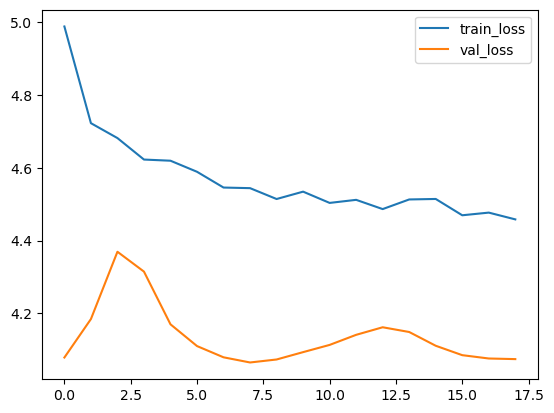

In [18]:
_ = log.plot()

We can get the partial log-likelihood

In [19]:
model.partial_log_likelihood(*val).mean()

-4.0651484

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

However, as `CoxPH` is semi-parametric, we first need to get the non-parametric baseline hazard estimates with `compute_baseline_hazards`. 

Note that for large datasets the `sample` argument can be used to estimate the baseline hazard on a subset.

In [20]:
_ = model.compute_baseline_hazards()

In [21]:
surv = model.predict_surv_df(x_test)

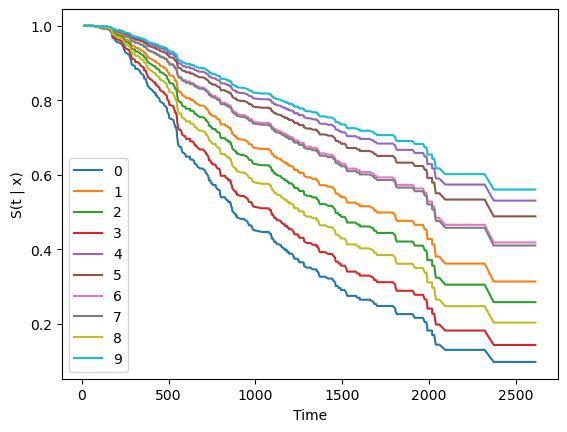

In [22]:
surv.iloc[:, :10].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Evaluation

We can use the `EvalSurv` class for evaluation the concordance, brier score and binomial log-likelihood. Setting `censor_surv='km'` means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [23]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [24]:
print(f"Concordance: {ev.concordance_td():.3f}")

Concordance: 0.642


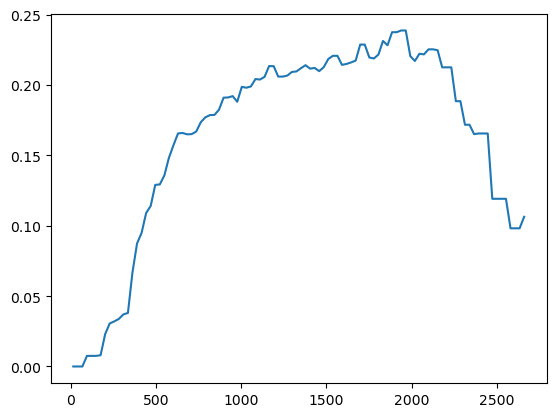

In [25]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [26]:
ev.integrated_brier_score(time_grid)

0.16457960562941268

In [27]:
ev.integrated_nbll(time_grid)

0.4904446756071374